In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import adam_v2
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data_v3.csv', header=[0])
df.shape

(377, 7)

In [3]:
df.head()

,Va,Vb,Vc,Ia,Ib,Ic,Status
0,228,228,231,51,52,48,normal
1,232,231,229,49,49,49,normal
2,230,232,231,51,48,50,normal
3,232,228,232,50,50,51,normal
4,231,232,231,48,52,49,normal


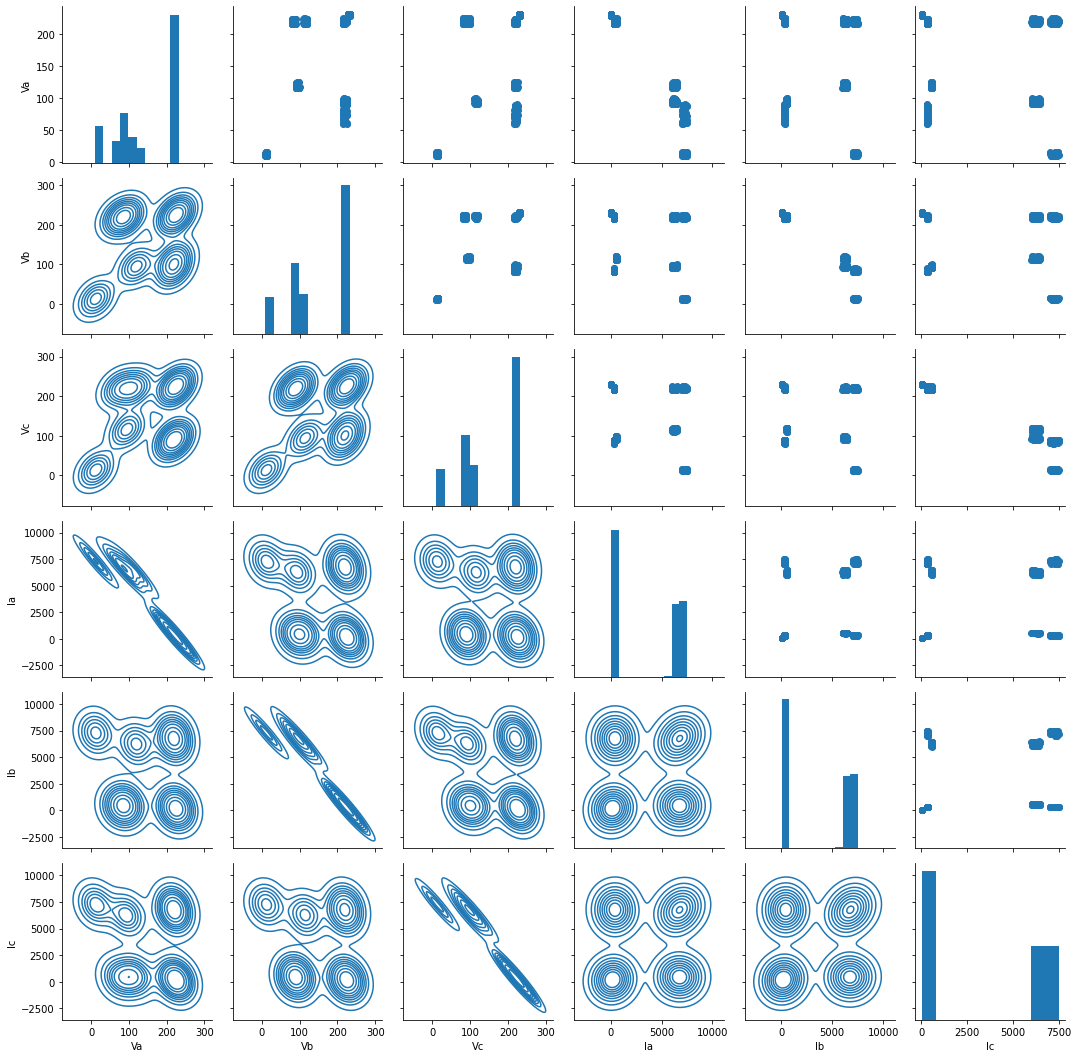

In [17]:
g = sns.PairGrid(df)
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)


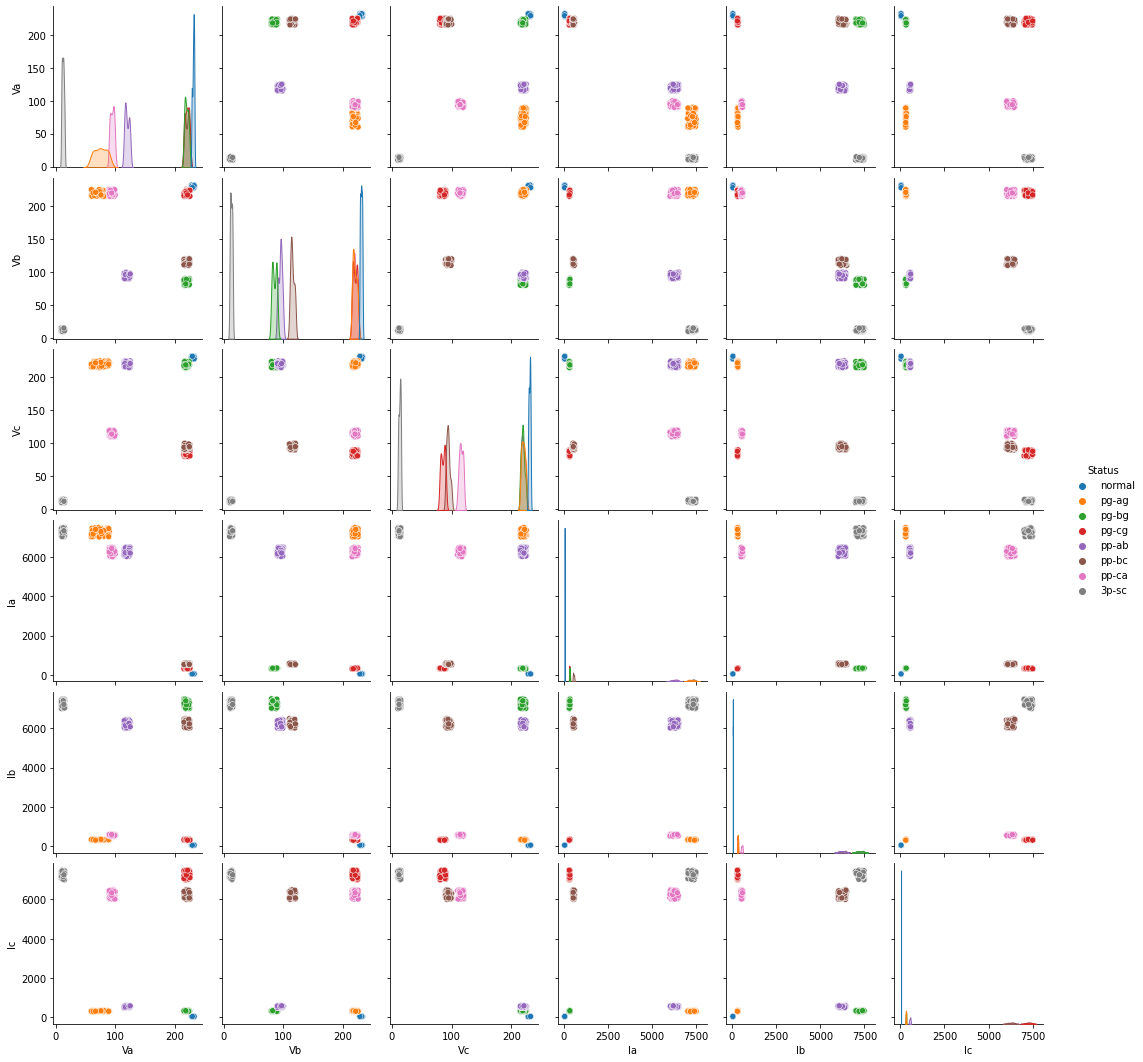

In [16]:
import seaborn
import matplotlib.pyplot as plt
#dataframe = pandas.read_csv("iris.data", names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species'])
seaborn.pairplot(df.iloc[:,0:7], hue="Status", diag_kind = 'kde')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values


In [ ]:
type(X), type(y)

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder()
y1 = encoder.fit_transform(y)
Y = pd.get_dummies(y1).values

from sklearn.model_selection import train_test_split
X_train,X_test, Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=0) 

In [ ]:
df.Status.value_counts()

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df = pd.DataFrame({'index':[0,1,2,3,4,5,6,7],
        'Status':['pg-ag','pg-bg','pg-cg','pp-ab','pp-bc','pp-ca','3p-sc', 'normal']})
df['Status_encoded'] = le.fit_transform(df['Status'].values)
df_encoded = df.drop_duplicates('Status').set_index('index')
print(df_encoded)

In [ ]:
List_Of_Categories_In_Column=list(df['Status'].value_counts().index)
List_Of_Categories_In_Column

In [ ]:
# encoded_categories = {0: 'normal', 1: 'pg-ag', 2: 'pg-bg', 3: 'pg-cg', 4: 'pp-ab', 5: 'pp-bc', 6: 'pp-ca', 7: '3p-sc'}
# encoded_categories

In [ ]:
n_features = X.shape[1]
n_classes = Y.shape[1]
n_classes, n_features

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Dense(2, input_dim=6, activation='relu'))
model.add(Dense(8, activation='softmax'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [ ]:
# In order to ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)


from keras.models import Sequential
from keras.layers import Dense

def create_custom_model(input_dim, output_dim, nodes, n=1, name='model'):
    def create_model():
        # Create model
        model = Sequential(name=name)
        for i in range(n):
            model.add(Dense(nodes, input_dim=input_dim, activation='relu'))
            model.add(Dense(output_dim, activation='softmax'))
            #plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
        
        # Compile model
        model.compile(loss='categorical_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])
        
        return model
    return create_model

models = [create_custom_model(n_features, n_classes, 8, i, 'model_{}'.format(i)) 
          for i in range(1, 6)]

for create_model in models:
    create_model().summary()
    

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [ ]:
from keras.callbacks import TensorBoard

history_dict = {}

# TensorBoard Callback
cb = TensorBoard()

for create_model in models:
    model = create_model()
    print('Model name:', model.name)
    history_callback = model.fit(X_train, Y_train,
                                 batch_size=5,
                                 epochs=50,
                                 verbose=0,
                                 validation_data=(X_test, Y_test),
                                 callbacks=[cb])
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    history_dict[model.name] = [history_callback, model]

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

for model_name in history_dict:
    val_accurady = history_dict[model_name][0].history['val_accuracy']
    val_loss = history_dict[model_name][0].history['val_loss']
    ax1.plot(val_accurady, label=model_name)
    ax2.plot(val_loss, label=model_name)
    
ax1.set_ylabel('validation accuracy')
ax2.set_ylabel('validation loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend();

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

for model_name in history_dict:
    model = history_dict[model_name][1]
    
    Y_pred = model.predict(X_test)
    fpr, tpr, threshold = roc_curve(Y_test.ravel(), Y_pred.ravel())
    
    plt.plot(fpr, tpr, label='{}, AUC = {:.3f}'.format(model_name, auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
from keras.models import model_from_json

In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

In [ ]:
encoded_categories

In [ ]:
loaded_model.summary()

In [ ]:
# result = loaded_model.predict(pd.DataFrame([87,220,220,7473,300,336]).T)

In [ ]:
# result

In [ ]:
df_e = pd.read_csv('data_eval.csv')
df_e

In [ ]:
from sklearn.model_selection import train_test_split
X_e = df_e.iloc[:, :-1].values
y_e = df_e.iloc[:, -1].values

In [ ]:
X_e

In [ ]:
y_e

In [ ]:
encoded_categories

In [ ]:
res = loaded_model.predict(X_e)

In [ ]:
res

In [ ]:
df_encoded

In [ ]:
np.argmax(X_e[2]),